# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler,StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
import pandas as pd
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("event_data") \
    .getOrCreate()

df = spark.read.json("mini_sparkify_event_data.json")    

In [3]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.count()

286500

In [6]:
df_new = df.dropna(how = "any", subset = ['userId', 'sessionId'])
df_new.count()

286500

In [7]:
df_new.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [8]:
df_new = df_new.filter(df.userId != "")
df_new.count()

278154

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [9]:
df_new.select("page").dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [10]:
flag_downgrade_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [11]:
df_new = df_new.withColumn("Churn", flag_downgrade_event("page"))

In [12]:
new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%m-%d-%Y %H:%M:%S"))

In [13]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [14]:
df = df_new.toPandas()

In [15]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


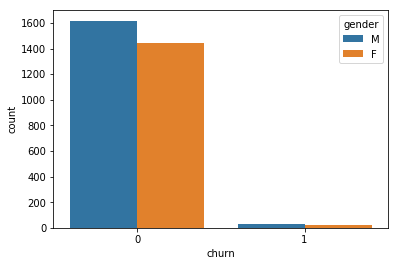

In [16]:
df_pd = df_new.dropDuplicates(["userId", "gender","page"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

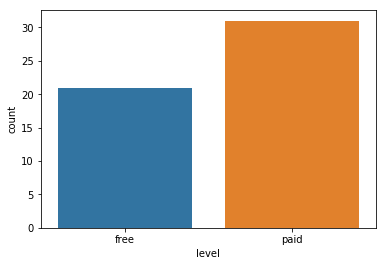

In [17]:
df_pd2 = df_new.filter(df_new.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd2)

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [18]:
feature1= df_new\
        .select('userId','page')\
        .where(df_new.page=='Thumbs Up')\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count','total_thumbs_up')
feature1.show()

+------+---------------+
|userId|total_thumbs_up|
+------+---------------+
|100010|             17|
|200002|             21|
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
|   155|             58|
|   132|             96|
|   154|             11|
|100014|             17|
|   101|             86|
|    11|             40|
|   138|             95|
|300017|            303|
|    29|            154|
|    69|             72|
|100021|             11|
|    42|            166|
|   112|              9|
+------+---------------+
only showing top 20 rows



In [19]:
feature2 = df_new\
        .select('userId','page')\
        .where(df_new.page=='Thumbs Down')\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count','total_thumbs_down')
feature2.show()

+------+-----------------+
|userId|total_thumbs_down|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
|    15|               14|
|    54|               29|
|   155|                3|
|   132|               17|
|100014|                3|
|   101|               16|
|    11|                9|
|   138|               24|
|300017|               28|
|    29|               22|
|    69|                9|
|100021|                5|
|    42|               25|
|   112|                3|
|    73|                7|
+------+-----------------+
only showing top 20 rows



In [20]:
df_gender = df_new.dropDuplicates(['userId','page']).sort('userId').select(['userId','gender'])
feature3 = df_gender.replace(['F','M'], ['0','1'], 'gender')
feature3 = feature3.withColumn('gender', feature3.gender.cast("int"))
feature3.show()

+------+------+
|userId|gender|
+------+------+
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|    10|     1|
|   100|     1|
|   100|     1|
|   100|     1|
|   100|     1|
|   100|     1|
|   100|     1|
|   100|     1|
+------+------+
only showing top 20 rows



In [21]:
df_final = df_new.dropDuplicates(['userId','page']).sort('userId').select(['userId','churn'])
for feature in [feature1,feature2,feature3]:
    df_final = df_final.join(feature,'userId')

In [22]:
df_final.drop('user_id').show()

+------+-----+---------------+-----------------+------+
|userId|churn|total_thumbs_up|total_thumbs_down|gender|
+------+-----+---------------+-----------------+------+
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|     0|
|100010|    0|             17|                5|

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [23]:
cols = ["total_thumbs_up","total_thumbs_down","gender"]
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(df_final)

In [24]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [25]:
train, rest = data.randomSplit([0.6, 0.4], seed = 42)
test, validation = rest.randomSplit([0.5, 0.5], seed = 42)

# Logistic Regression

In [26]:
model_lr = LogisticRegression(labelCol = 'churn', featuresCol = 'features')
model_lr = model_lr.fit(train)

In [27]:
predict_train_lr = model_lr.transform(train)
predict_test_lr = model_lr.transform(test)

In [28]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='churn')
print('ROC for train set is{}'.format(evaluator.evaluate(predict_train_lr)))
print('ROC for test set is{}'.format(evaluator.evaluate(predict_test_lr)))

ROC for train set is0.6676883438432599
ROC for test set is0.6492181643953117


# Random Forest 

In [29]:
model_rf = RandomForestClassifier(labelCol = 'churn', featuresCol = 'features')
model_rf = model_rf.fit(train)

In [30]:
predict_train_rf = model_rf.transform(train)
predict_test_rf = model_rf.transform(test)

In [31]:
evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='churn')
print('ROC for train set is{}'.format(evaluator2.evaluate(predict_train_rf)))
print('ROC for test set is{}'.format(evaluator2.evaluate(predict_test_rf)))

ROC for train set is0.5
ROC for test set is0.5


# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。